# Open Street Map

In [20]:
import osmnx as ox
import cartopy.crs as ccrs
ox.settings.log_console=False
ox.settings.use_cache=True

In [21]:
(COORDS, DIST) = ((10.6376,-4.7526), 200)
PROJ = ccrs.PlateCarree()

In [22]:
BLD = ox.geometries.geometries_from_point(
    COORDS, tags={'building': True} , dist=DIST
)
NTW = ox.graph_from_point(
    COORDS, dist=DIST, network_type='all',
    retain_all=True, simplify=True, truncate_by_edge=True
)
BLD['centroid_lon'] = [poly.centroid.x for poly in BLD['geometry']]
BLD['centroid_lat'] = [poly.centroid.y for poly in BLD['geometry']]
BLD.reset_index(inplace=True)

/var/folders/k2/wvkkz5nn4zbbx6rt5csw2t0m0000gq/T/ipykernel_99959/3517508826.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  BLD = ox.geometries.geometries_from_point(
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda

In [23]:
STYLE_GD_A = {'color': '#8da9c4', 'alpha': 0.5, 'width': 0.5, 'step': 0.01, 'range': 1, 'style': ':'}
STYLE_BG_A = {'color': '#0b2545'}
STYLE_TX_A = {'color': '#faf9f9', 'size': 40}
STYLE_CN_A = {'color': '#faf9f9', 'alpha': 0.20, 'size': 200}
STYLE_BD_A = {'color': '#faf9f9', 'alpha': 0.900}
STYLE_RD_A = {'color': '#ede0d4', 'alpha': 0.125, 'width': 1.5}
MAP_STYLE_A = (
    STYLE_GD_A, STYLE_BG_A, STYLE_TX_A, 
    STYLE_CN_A, STYLE_BD_A, STYLE_RD_A
)
(STYLE_GD, STYLE_BG, STYLE_TX, STYLE_CN, STYLE_BD, STYLE_RD) = MAP_STYLE_A

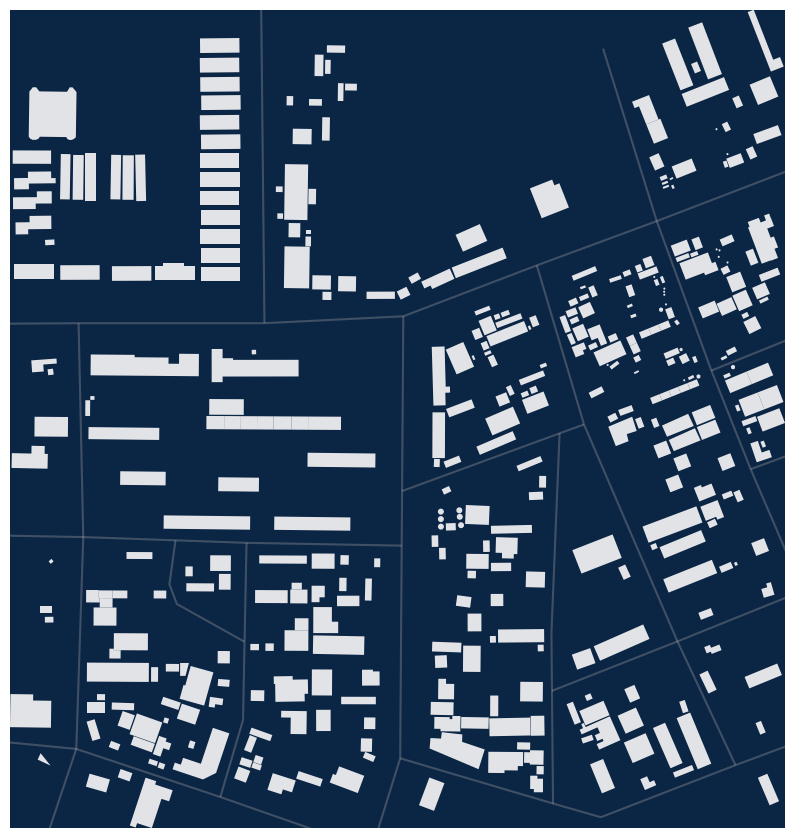

In [26]:
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, node_size=0, figsize=(10, 100), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)

In [25]:
BLD

,element_type,osmid,nodes,building,geometry,amenity,name,source,centroid_lon,centroid_lat
0,way,214800458,"[2242750936, 2242750926, 2242750940, 224275094...",yes,"POLYGON ((-4.75163 10.63646, -4.75160 10.63639...",NaN,NaN,NaN,-4.751487,10.636476
1,way,214800475,"[2242750999, 2242750987, 2242750997, 224275101...",yes,"POLYGON ((-4.75174 10.63693, -4.75169 10.63682...",NaN,NaN,NaN,-4.751611,10.636914
2,way,214800481,"[2242750930, 2242750935, 2242750925, 224275091...",yes,"POLYGON ((-4.75174 10.63642, -4.75165 10.63645...",NaN,NaN,NaN,-4.751678,10.636395
3,way,220877637,"[2299571291, 2299571276, 2299571281, 229957129...",yes,"POLYGON ((-4.75360 10.63834, -4.75360 10.63826...",NaN,NaN,NaN,-4.753505,10.638300
4,way,220877642,"[2299571371, 2299571363, 2299571365, 229957137...",yes,"POLYGON ((-4.75361 10.63871, -4.75361 10.63864...",NaN,NaN,NaN,-4.753511,10.638676
...,...,...,...,...,...,...,...,...,...,...
394,way,570548861,"[5485424198, 5485424199, 5485424200, 548542420...",yes,"POLYGON ((-4.75244 10.63701, -4.75241 10.63701...",NaN,NaN,NaN,-4.752427,10.636978
395,way,570548862,"[5485424202, 5485424203, 5485424204, 548542420...",yes,"POLYGON ((-4.75218 10.63698, -4.75215 10.63698...",NaN,NaN,NaN,-4.752168,10.636953
396,way,570548863,"[5485424206, 5485424207, 5485424208, 548542420...",yes,"POLYGON ((-4.75243 10.63734, -4.75243 10.63738...",NaN,NaN,NaN,-4.752417,10.637364
397,way,570550447,"[5485440531, 5485440532, 5485440533, 548544053...",yes,"POLYGON ((-4.75121 10.63610, -4.75110 10.63585...",NaN,NaN,NaN,-4.751123,10.635990
